In [1]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))

In [4]:
def prepare_mnist_data(mnist):
  
  # create extra dimension for conv2D needs 4D
  mnist = mnist.map(lambda img, img2: (tf.expand_dims(img, -1), tf.expand_dims(img2, -1)))

  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, img2: (tf.cast(img, tf.float32), tf.cast(img2, tf.float32)))
  #sloppy input normalization, just bringing image values from range [0, 255] to [0, 1]
  mnist = mnist.map(lambda img, img2: ((img/255), (img2/255)))
  #create noise
  mnist = mnist.map(lambda img, img2: (tf.clip_by_value((img + tf.random.normal(mean=0.0, stddev=1.0, shape=img.shape)), 0.0, 1.0), img2 ))
  
  

  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(len(mnist))
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(100)
  #return preprocessed dataset
  return mnist

train_data = train_dataset.apply(prepare_mnist_data)
test_data = test_dataset.apply(prepare_mnist_data)

In [5]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation= "relu")

        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides = 2, padding='same', activation = "relu")

        self.flatten1 = tf.keras.layers.Flatten()

        self.dense1 = tf.keras.layers.Dense(units= 64 * 7 * 7, activation= "relu")

    def call(self, inputs):
        x = self.conv1(inputs)                                       
        x = self.conv2(x)                                           
        x = self.flatten1(x)                      
        out = self.dense1(x)  
        return out

In [6]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(units= 64 * 7 * 7, activation= "relu")

        self.reshape1 = tf.keras.layers.Reshape((7,7,64))

        self.convtrans1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation= "relu")

        self.convtrans2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation= "relu")

        self.conv1 = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)                 
        x = self.reshape1(x)                                       
        x = self.convtrans1(x)                  
        x = self.convtrans2(x)                
        out = self.conv1(x)
        return out

In [7]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        enc = self.encoder(inputs)
        dec = self.decoder(enc)
        return dec

In [8]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for input, target in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    test_loss_aggregator.append(sample_test_loss.numpy())
    #test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  #test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss

In [9]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 5
learning_rate = 0.001

# Initialize the model.
model = Autoencoder()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
mse_loss = tf.keras.losses.MeanSquaredError()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss = test(model, test_data, mse_loss)
test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss = test(model, train_data, mse_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with loss {test_losses[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_data:
        train_loss = train_step(model, input, target, mse_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss = test(model, test_data, mse_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)

Epoch: 0 starting with loss 0.23084722459316254
Epoch: 1 starting with loss 0.028094489127397537
Epoch: 2 starting with loss 0.0269295834004879
Epoch: 3 starting with loss 0.02693956345319748
Epoch: 4 starting with loss 0.027757832780480385


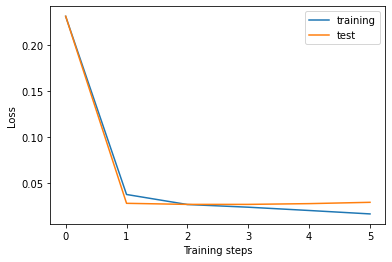

In [10]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

In [11]:
data = x_test[:1000]
data_labels = y_test[:1000]
data = tf.expand_dims(tf.cast(data, tf.float32)/255, -1)
enc = model.encoder(data)
enc = np.reshape(enc, (enc.shape[0], -1))

In [12]:
embed = TSNE(n_components=2, perplexity=30).fit_transform(enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


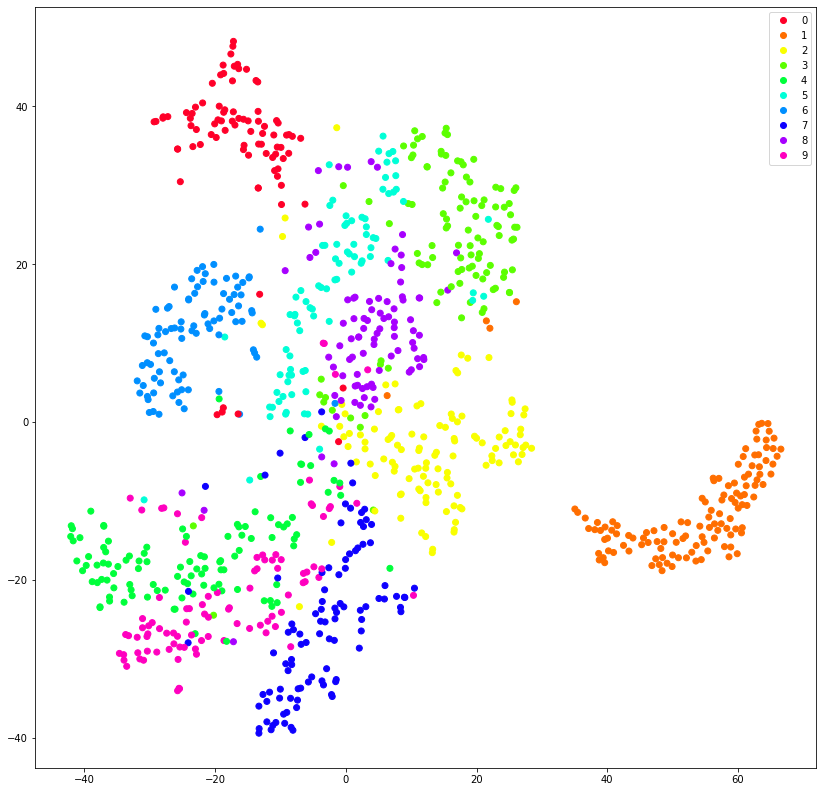

In [13]:
label_names=[str(l) for l in np.arange(10)]
fig = plt.figure(figsize=(14, 14))
scatter = plt.scatter(embed[:,0], embed[:,1], c=data_labels, cmap='gist_rainbow')
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)

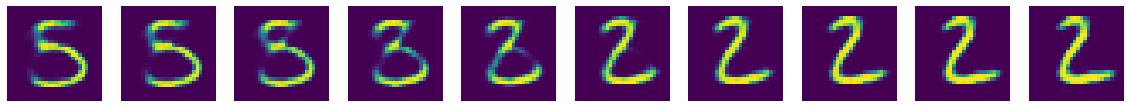

In [49]:
# interpolate linearly between the embeddings of two images and plot the reconstructed images
two_number_images = tf.convert_to_tensor([data[1], data[15]])
encoded = model.encoder(two_number_images)
encoded_1 = encoded[0]
encoded_2 = encoded[1]
number_of_interpol = 10
percent_of_interpol = np.linspace(0, 1, number_of_interpol)
interpolations = []
for percent in percent_of_interpol:
    interpolations.append(encoded_1*percent + encoded_2*(1-percent))
rec_imgs = model.decoder(tf.convert_to_tensor(interpolations))

# plot the reconstructed images
fig = plt.figure(figsize=(2*number_of_interpol,20))
for i in range(number_of_interpol):
    plt.subplot(1, number_of_interpol, i+1)
    plt.imshow(tf.squeeze(rec_imgs[i]))
    plt.axis('off')
plt.show()